# iTransformer Wind Power Prediction Model

This notebook implements an iTransformer (Inverted Transformer) model for 16-point wind power prediction. iTransformer is the state-of-the-art model for multivariate time series forecasting, published in 2024.

## Key Features:


In [1]:
# ===== iTransformer Configuration =====


class iTransformerConfig:
    # Data configuration
    seq_length = 96          # Input sequence length (96 points, 24 hours, 15min intervals)
    pred_length = 16         # Prediction sequence length (16 points, 4 hours)
    train_val_split = 0.8    # Train/validation split ratio
    
    # Data loading
    batch_size = 128         
    num_workers = 8          # DataLoader workers
    
    # Feature engineering
    use_feature_engineering = True  # 是否使用特征工程
    time_interval_minutes = 15

    add_trend_features = True        # 趋势特征

    add_lag_features = True        # 添加滞后特征
    lag_steps = [1, 2, 4, 8, 16, 24, 48, 96]  #
    
    add_ramp_features = True       # 添加功率爬坡特征
    ramp_windows = [4, 8, 16]       # 爬坡检测窗口

    add_anomaly_features = True      # 异常检测特征
    anomaly_windows = [24, 96]       # 异常检测的滚动窗口大小

    add_statistical_features = True  # 统计滚动特征
    statistical_windows = [4, 8, 16, 24, 48, 96]  # 统计特征的滚动窗口大小
    enable_rolling_mean = True       # 启用滚动均值
    enable_rolling_std = True        # 启用滚动标准差
    enable_rolling_max = True        # 启用滚动最大值
    enable_rolling_min = True        # 启用滚动最小值
    enable_rolling_range = True      # 启用滚动范围


    # iTransformer model structure
    d_model = 64            # Transformer维度（较小以适应小数据）
    nhead = 8                # 注意力头数
    num_encoder_layers = 2   # 编码器层数
    dim_feedforward = 256   # FFN dimension
    dropout = 0.1            # Dropout rate
    activation = 'gelu'      # Activation function
    
    # Training configuration
    num_epochs = 300         # Training epochs
    learning_rate = 0.0001   # Learning rate

    huber_delta = 1.0  
    
    # Learning rate scheduling
    lr_patience = 8          # LR scheduler patience
    lr_factor = 0.5          # LR decay factor
    
    # Early stopping
    early_stop_patience = 50 
    early_stop_min_delta = 0.0001
    
    # System configuration
    random_seed = 42
    gpu_device = '7'
    print_freq = 50
    
    # Path configuration
    data_dir = '/data/jinming/ee_prediction/data'
    model_save_dir = '/data/jinming/ee_prediction/iTransformer/models'
    results_dir = '/data/jinming/ee_prediction/iTransformer/results'

# Create configuration instance
config = iTransformerConfig()

print("=== iTransformer Configuration ===")
print(f"Time Configuration: {config.seq_length} points -> {config.pred_length} points")
print(f"Model: d_model={config.d_model}, nhead={config.nhead}, layers={config.num_encoder_layers}")
print(f"Training: batch_size={config.batch_size}, lr={config.learning_rate}, epochs={config.num_epochs}")
print("=" * 50)

=== iTransformer Configuration ===
Time Configuration: 96 points -> 16 points
Model: d_model=64, nhead=8, layers=2
Training: batch_size=128, lr=0.0001, epochs=300


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')

# GPU setup
os.environ['CUDA_VISIBLE_DEVICES'] = config.gpu_device

# Set random seeds for reproducibility
np.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.random_seed)
    torch.cuda.manual_seed_all(config.random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} (GPU {config.gpu_device})')
if torch.cuda.is_available():
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda (GPU 7)
GPU device: NVIDIA RTX A6000
GPU memory: 47.44 GB


In [3]:
# iTransformer Model Definition
# Based on "iTransformer: Inverted Transformers Are Effective for Time Series Forecasting"

class VariableEmbedding(nn.Module):
    """Variable-wise embedding for iTransformer"""
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Linear projection from sequence length to model dimension
        self.projection = nn.Linear(seq_len, d_model)
        
    def forward(self, x):
        # x: [batch_size, seq_len, n_vars]
        # Transpose to [batch_size, n_vars, seq_len]
        x = x.transpose(1, 2)
        
        # Project each variable independently: [batch_size, n_vars, d_model]
        x = self.projection(x)
        
        return x

class VariablePositionalEncoding(nn.Module):
    """Positional encoding for variables instead of time steps"""
    def __init__(self, d_model, max_vars=1000):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encoding for variables
        pe = torch.zeros(max_vars, d_model)
        position = torch.arange(0, max_vars, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_vars, d_model]
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: [batch_size, n_vars, d_model]
        batch_size, n_vars, d_model = x.shape
        x = x + self.pe[:, :n_vars, :]
        return x

class iTransformerLayer(nn.Module):
    """Single iTransformer encoder layer"""
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation):
        super().__init__()
        
        # Multi-head self-attention
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Self-attention
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        
        return x

class iTransformer(nn.Module):
    """iTransformer: Inverted Transformer for Time Series Forecasting"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.seq_len = config.seq_length
        self.pred_len = config.pred_length
        self.d_model = config.d_model
        
        # Input feature dimension (will be set dynamically)
        self.n_vars = getattr(config, 'input_size', 1)
        
        # Variable embedding: project each variable from seq_len to d_model
        self.variable_embedding = VariableEmbedding(self.seq_len, self.d_model)
        
        # Variable positional encoding
        self.variable_pos_encoding = VariablePositionalEncoding(self.d_model)
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            iTransformerLayer(
                d_model=config.d_model,
                nhead=config.nhead,
                dim_feedforward=config.dim_feedforward,
                dropout=config.dropout,
                activation=config.activation
            )
            for _ in range(config.num_encoder_layers)
        ])
        
        # Output projection: from d_model to prediction length
        self.output_projection = nn.Linear(self.d_model, self.pred_len)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize model weights"""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
                
    def update_input_size(self, input_size):
        """Dynamically update input feature dimension"""
        self.n_vars = input_size
        # No need to recreate layers since iTransformer handles variable dimensions automatically
        
    def forward(self, x):
        # x: [batch_size, seq_len, n_vars]
        batch_size, seq_len, n_vars = x.shape
        
        # Variable embedding: [batch_size, n_vars, d_model]
        x = self.variable_embedding(x)
        
        # Add variable positional encoding
        x = self.variable_pos_encoding(x)
        
        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Output projection: [batch_size, n_vars, pred_len]
        output = self.output_projection(x)
        
        # For univariate prediction, use the first variable (power)
        # For multivariate, you might want to use specific variables or aggregation
        if n_vars == 1:
            output = output.squeeze(1)  # [batch_size, pred_len]
        else:
            # Use the first variable (original power) as target
            output = output[:, 0, :]  # [batch_size, pred_len]
            
        return output

print("iTransformer model class defined successfully!")

iTransformer model class defined successfully!


In [4]:
# Data loading and preprocessing (reuse from previous notebooks)
train_data = pd.read_excel(f'{config.data_dir}/train.xlsx')
test_data = pd.read_excel(f'{config.data_dir}/test.xlsx')

train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

print(f"Training data length: {len(train_power)}")
print(f"Testing data length: {len(test_power)}")
print(f"Training data range: [{train_power.min():.4f}, {train_power.max():.4f}]")
print(f"Testing data range: [{test_power.min():.4f}, {test_power.max():.4f}]")

# Simplified data preprocessing
def simplified_data_preprocessing(data, config):
    processed_data = data.copy()
    processed_data = np.where(processed_data < 0, 0, processed_data)
    
    negative_count = np.sum(data < 0)
    if negative_count > 0:
        print(f"Converted {negative_count} negative values to 0")
    else:
        print("No negative values found")
    
    return processed_data, None

print("\n=== Data Preprocessing ===")
train_power_processed, _ = simplified_data_preprocessing(train_power, config)
test_power_processed, _ = simplified_data_preprocessing(test_power, config)

print(f"Final training data range: [{train_power_processed.min():.4f}, {train_power_processed.max():.4f}]")
print(f"Final testing data range: [{test_power_processed.min():.4f}, {test_power_processed.max():.4f}]")

Training data length: 6999
Testing data length: 2999
Training data range: [-0.0094, 1.0000]
Testing data range: [-0.0093, 0.9446]

=== Data Preprocessing ===
Converted 445 negative values to 0
Converted 138 negative values to 0
Final training data range: [0.0000, 1.0000]
Final testing data range: [0.0000, 0.9446]


In [5]:
# 数据集类定义
class EnhancedPowerDataset(Dataset):
    def __init__(self, data, seq_length=96, pred_length=16, step=1, config=None):
        """
        增强的电力数据集类（支持全面特征工程）
        
        参数:
        data: 原始时间序列数据
        seq_length: 输入序列长度
        pred_length: 预测序列长度
        step: 滑动窗口步长
        config: 配置对象
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.step = step
        self.config = config
        
        # 创建特征
        if config and config.use_feature_engineering:
            self.features, self.feature_names = self._create_enhanced_features()
            print(f"Created {self.features.shape[1]} features: {len(self.feature_names)} total")
            print(f"Feature categories: {self._get_feature_categories()}")
            
            # 特征选择（如果启用）
            if getattr(config, 'enable_feature_selection', False) and self.features.shape[1] > config.max_features:
                self.features, self.feature_names = self._apply_feature_selection()
                print(f"After feature selection: {self.features.shape[1]} features")
        else:
            self.features = data.reshape(-1, 1)
            self.feature_names = ['power']
        
        # 创建输入输出对
        self.X, self.y = self._create_sequences()

    def _get_feature_categories(self):
        """获取特征类别统计"""
        categories = {}
        for name in self.feature_names:
            if name == 'power':
                category = 'original'
            elif name.startswith('lag_'):
                category = 'lag'
            elif name.startswith('ramp_'):
                category = 'ramp'
            elif name.startswith('rolling_'):
                category = 'statistical'
            elif 'outlier' in name or 'anomaly' in name:
                category = 'anomaly'
            elif name.endswith(('_sin', '_cos')) or 'time' in name or 'hour' in name or 'weekday' in name or 'month' in name or 'season' in name:
                category = 'temporal'
            elif name.startswith(('diff_', 'pct_', 'cumulative_', 'relative_')):
                category = 'trend'
            elif name.startswith('power_level_') or name in ['zero_power', 'full_power', 'power_level_change']:
                category = 'power_state'
            elif name.startswith(('volatility_', 'cv_', 'skewness_', 'kurtosis_')):
                category = 'volatility'
            elif name.startswith(('diff_historical_', 'ratio_historical_')) or name == 'is_weekend':
                category = 'cross_temporal'
            elif name in ['dominant_frequency', 'spectral_energy']:
                category = 'frequency'
            else:
                category = 'other'
            
            categories[category] = categories.get(category, 0) + 1
        
        return categories


    def add_trend_features(self, power_series):
        """添加趋势和变化率特征（归一化版本）"""
        features = []
        feature_names = []
        
        # 一阶差分（变化率）- 归一化
        diff_1 = power_series.diff(1).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_1_normalized = np.clip(diff_1.values, -0.5, 0.5)
        features.append(diff_1_normalized)
        feature_names.append('diff_1')
        
        # 二阶差分（加速度）- 归一化
        diff_2 = power_series.diff(2).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_2_normalized = np.clip(diff_2.values, -0.3, 0.3)
        features.append(diff_2_normalized)
        feature_names.append('diff_2')
        
        return features, feature_names


    def add_statistical_features(self, power_series):
        """添加统计滚动窗口特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # 使用config中的统计窗口参数
        windows = self.config.statistical_windows
        
        for window in windows:
            # 滚动均值
            if self.config.enable_rolling_mean:
                rolling_mean = power_series.rolling(window=window, min_periods=1).mean().fillna(0).values
                features.append(rolling_mean)
                feature_names.append(f'rolling_mean_{window}')
            
            # 滚动标准差
            if self.config.enable_rolling_std:
                rolling_std = power_series.rolling(window=window, min_periods=1).std().fillna(0).values
                features.append(rolling_std)
                feature_names.append(f'rolling_std_{window}')
            
            # 滚动最大值
            if self.config.enable_rolling_max:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(rolling_max)
                feature_names.append(f'rolling_max_{window}')
            
            # 滚动最小值
            if self.config.enable_rolling_min:
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                features.append(rolling_min)
                feature_names.append(f'rolling_min_{window}')
            
            # 滚动范围（max - min）
            if self.config.enable_rolling_range and self.config.enable_rolling_max and self.config.enable_rolling_min:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                rolling_range = rolling_max - rolling_min
                features.append(rolling_range)
                feature_names.append(f'rolling_range_{window}')
        
        return features, feature_names

    def add_anomaly_features(self, power_series):
        """添加异常检测特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # Z-score异常检测
        z_scores = np.abs((power_series - power_series.mean()) / power_series.std())
        is_outlier = (z_scores > 2).astype(int).values  # 2个标准差外为异常
        features.append(is_outlier)
        feature_names.append('is_outlier')
        
        # IQR异常检测
        Q1 = power_series.quantile(0.25)
        Q3 = power_series.quantile(0.75)
        IQR = Q3 - Q1
        is_iqr_outlier = ((power_series < (Q1 - 1.5 * IQR)) | 
                          (power_series > (Q3 + 1.5 * IQR))).astype(int).values
        features.append(is_iqr_outlier)
        feature_names.append('is_iqr_outlier')
        
        # 局部异常因子（使用config中的异常窗口参数）
        windows = self.config.anomaly_windows
        for window in windows:
            local_mean = power_series.rolling(window=window, center=True).mean()
            local_std = power_series.rolling(window=window, center=True).std()
            local_anomaly = np.abs(power_series - local_mean) > (2 * local_std)
            features.append(local_anomaly.fillna(0).astype(int).values)
            feature_names.append(f'local_anomaly_{window}')
        
        return features, feature_names
    
    def _apply_feature_selection(self):
        """应用特征选择"""
        from sklearn.feature_selection import VarianceThreshold
        
        # 方差阈值过滤
        selector = VarianceThreshold(threshold=0.001)
        features_filtered = selector.fit_transform(self.features)
        selected_features = [name for i, name in enumerate(self.feature_names) 
                            if selector.get_support()[i]]
        
        # 如果仍然超过最大特征数，随机选择
        if len(selected_features) > self.config.max_features:
            np.random.seed(self.config.random_seed)
            indices = np.random.choice(len(selected_features), self.config.max_features, replace=False)
            features_filtered = features_filtered[:, indices]
            selected_features = [selected_features[i] for i in indices]
        
        return features_filtered, selected_features
    
    def _create_enhanced_features(self):
        """创建增强的特征（完整版）"""
        features = []
        feature_names = []
        
        power_series = pd.Series(self.data)
        
        # 1. 原始功率数据
        features.append(self.data)
        feature_names.append('power')
        
        # 2. 滞后特征
        if self.config.add_lag_features:
            for lag in self.config.lag_steps:
                if lag < len(self.data):
                    lag_feature = np.roll(self.data, lag)
                    lag_feature[:lag] = lag_feature[lag]
                    features.append(lag_feature)
                    feature_names.append(f'lag_{lag}')
        
        # 3. 功率爬坡特征
        if self.config.add_ramp_features:
            for window in self.config.ramp_windows:
                # 功率爬坡率：单位时间内功率变化幅度
                ramp_rate = power_series.diff(window).fillna(0).values
                features.append(ramp_rate)
                feature_names.append(f'ramp_rate_{window}')
                
                # 绝对爬坡率
                abs_ramp_rate = np.abs(ramp_rate)
                features.append(abs_ramp_rate)
                feature_names.append(f'abs_ramp_rate_{window}')
                
                # 功率爬坡强度（滚动窗口内最大绝对变化）
                ramp_intensity = power_series.diff().abs().rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(ramp_intensity)
                feature_names.append(f'ramp_intensity_{window}')
                
                # 爬坡方向（上升=1，下降=-1，稳定=0）
                ramp_direction = np.sign(ramp_rate)
                features.append(ramp_direction)
                feature_names.append(f'ramp_direction_{window}')
        
        # 4. 统计滚动特征
        if self.config.add_statistical_features:
            stat_features, stat_names = self.add_statistical_features(power_series)
            features.extend(stat_features)
            feature_names.extend(stat_names)

        # 5. 异常检测特征
        if self.config.add_anomaly_features:
            anomaly_features, anomaly_names = self.add_anomaly_features(power_series)
            features.extend(anomaly_features)
            feature_names.extend(anomaly_names)
        
        
        # 6. 新增：趋势特征
        if getattr(self.config, 'add_trend_features', True):
            trend_features, trend_names = self.add_trend_features(power_series)
            features.extend(trend_features)
            feature_names.extend(trend_names)
        
    
        return np.array(features).T, feature_names  # [time_steps, num_features]
    
    def _create_sequences(self):
        X, y = [], []
        for i in range(0, len(self.data) - self.seq_length - self.pred_length + 1, self.step):
            # 多特征输入序列
            X.append(self.features[i:i + self.seq_length])
            # 输出序列（仍然是原始功率数据）
            y.append(self.data[i + self.seq_length:i + self.seq_length + self.pred_length])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])




# 创建训练数据集
print("Creating training dataset...")
train_dataset = EnhancedPowerDataset(
    data=train_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Training dataset created successfully!")
print(f"Dataset length: {len(train_dataset)}")
print(f"Features shape: {train_dataset.features.shape}")
print(f"Input sequences shape: {train_dataset.X.shape}")
print(f"Target sequences shape: {train_dataset.y.shape}")

# 创建测试数据集
print("\nCreating test dataset...")
test_dataset = EnhancedPowerDataset(
    data=test_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Test dataset created successfully!")
print(f"Dataset length: {len(test_dataset)}")
print(f"Features shape: {test_dataset.features.shape}")
print(f"Input sequences shape: {test_dataset.X.shape}")
print(f"Target sequences shape: {test_dataset.y.shape}")

# 更新config中的input_size
config.input_size = train_dataset.features.shape[1]
print(f"\nUpdated config.input_size to: {config.input_size}")

# 检查特征范围（不进行归一化）
print(f"\nFeature Statistics (Raw Features - No Normalization):")
print(f"Features range: [{train_dataset.features.min():.6f}, {train_dataset.features.max():.6f}]")
print(f"Features mean: {train_dataset.features.mean():.6f}")
print(f"Features std: {train_dataset.features.std():.6f}")
print(f"Target values range: [{train_dataset.data.min():.6f}, {train_dataset.data.max():.6f}]")

# 检查是否有异常值
has_nan = np.isnan(train_dataset.features).any()
has_inf = np.isinf(train_dataset.features).any()
has_very_large = np.any(np.abs(train_dataset.features) > 1e6)

print(f"\nData Quality Check:")
print(f"Has NaN values: {has_nan}")
print(f"Has Inf values: {has_inf}")
print(f"Has very large values (>1e6): {has_very_large}")

if has_nan or has_inf or has_very_large:
    print("⚠️  WARNING: Found problematic values in features!")
    print("🔧 Applying safe replacement (NaN/Inf → 0)...")
    train_dataset.features = np.nan_to_num(train_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    test_dataset.features = np.nan_to_num(test_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 重新创建序列
    train_dataset.X, train_dataset.y = train_dataset._create_sequences()
    test_dataset.X, test_dataset.y = test_dataset._create_sequences()
    print("✅ Problematic values replaced, sequences recreated")
else:
    print("✅ No problematic values found")



# 创建数据加载器
print("\n" + "="*60)
print("CREATING DATA LOADERS")


# 分割训练集和验证集
train_size = int(config.train_val_split * len(train_dataset))
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))

train_dataset_split = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

# 创建数据加载器
train_loader = DataLoader(train_dataset_split, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

print(f"Training set size: {len(train_dataset_split)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

print(f"Total features: {len(train_dataset.feature_names)}")
print(f"Feature categories: {train_dataset._get_feature_categories()}")
print(f"Ready for training!")

Creating training dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}
Training dataset created successfully!
Dataset length: 6888
Features shape: (6999, 57)
Input sequences shape: (6888, 96, 57)
Target sequences shape: (6888, 16)

Creating test dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}
Test dataset created successfully!
Dataset length: 2888
Features shape: (2999, 57)
Input sequences shape: (2888, 96, 57)
Target sequences shape: (2888, 16)

Updated config.input_size to: 57

Feature Statistics (Raw Features - No Normalization):
Features range: [-1.000000, 1.000000]
Features mean: 0.167196
Features std: 0.321856
Target values range: [0.000000, 1.000000]

Data Quality Check:
Has NaN values: False
Has Inf values: False
Has very large values (>1e6): False
✅ No problematic values 

In [6]:
# Create iTransformer model
model = iTransformer(config).to(device)

# Update model's input dimension
model.update_input_size(config.input_size)

# Model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"=== iTransformer Model Information ===")
print(f"Input sequence length: {config.seq_length}")
print(f"Input features: {config.input_size}")
print(f"Model dimension: {config.d_model}")
print(f"Attention heads: {config.nhead}")
print(f"Encoder layers: {config.num_encoder_layers}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 50)

# Test forward pass
with torch.no_grad():
    sample_input = torch.randn(2, config.seq_length, config.input_size).to(device)
    sample_output = model(sample_input)
    print(f"Test forward pass - Input shape: {sample_input.shape}, Output shape: {sample_output.shape}")

=== iTransformer Model Information ===
Input sequence length: 96
Input features: 57
Model dimension: 64
Attention heads: 8
Encoder layers: 2
Total parameters: 107,216
Trainable parameters: 107,216
Test forward pass - Input shape: torch.Size([2, 96, 57]), Output shape: torch.Size([2, 16])


In [7]:
# Loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.learning_rate, 
    betas=(0.9, 0.95)  # Better for Transformers
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=config.lr_factor, 
    patience=config.lr_patience, verbose=True, min_lr=1e-6
)

# CR metric calculation
def calculate_CR(PM, PP):
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_cr = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_cr, model):
        if self.best_cr is None:
            self.best_cr = val_cr
            self.save_checkpoint(model)
        elif val_cr > self.best_cr + self.min_delta:
            self.best_cr = val_cr
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        return self.counter >= self.patience
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(
    patience=config.early_stop_patience, 
    min_delta=config.early_stop_min_delta
)

print(f"Training setup completed!")
print(f"Optimizer: AdamW (lr={config.learning_rate}")
print(f"Loss function: Huber Loss")
print(f"LR Scheduler: ReduceLROnPlateau (patience={config.lr_patience})")
print(f"Early stopping: patience={config.early_stop_patience}")

Training setup completed!
Optimizer: AdamW (lr=0.0001
Loss function: Huber Loss
LR Scheduler: ReduceLROnPlateau (patience=8)
Early stopping: patience=50


In [8]:
# Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device, config):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        
        if batch_idx % config.print_freq == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def calculate_validation_cr(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Calculate CR on all prediction points (correct approach)
    cr_overall = calculate_CR(targets.flatten(), predictions.flatten())
    return cr_overall

print("Training functions defined successfully!")

Training functions defined successfully!


In [9]:
# Start training
train_losses = []
val_losses = []
val_cr_scores = []

print("=== Starting iTransformer Training ===")
print(f"Model: iTransformer")
print(f"Training epochs: {config.num_epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Model parameters: {total_params:,}")
print("=" * 50)

best_epoch = 0
for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, config)
    train_losses.append(train_loss)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Calculate validation CR metric
    val_cr = calculate_validation_cr(model, val_loader, device)
    val_cr_scores.append(val_cr)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    print(f"Validation CR: {val_cr:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early stopping check
    if early_stopping(val_cr, model):
        print(f"\nEarly stopping triggered! Training stopped at epoch {epoch+1}")
        print(f"Best CR metric: {early_stopping.best_cr:.2f}%")
        best_epoch = epoch + 1
        break
    
    if val_cr == early_stopping.best_cr:
        best_epoch = epoch + 1

print("\n=== Training Completed ===")
print(f"Best validation CR: {early_stopping.best_cr:.2f}% (Epoch {best_epoch})")
print(f"Total epochs trained: {len(train_losses)}")

# Restore best weights
if early_stopping.best_weights is not None:
    model.load_state_dict(early_stopping.best_weights)
    print("Restored best model weights")

=== Starting iTransformer Training ===
Model: iTransformer
Training epochs: 300
Batch size: 128
Learning rate: 0.0001
Model parameters: 107,216

Epoch 1/300
  Batch 0/44, Loss: 0.529845
Train Loss: 0.188938, Val Loss: 0.022690
Validation CR: 13.23%
Current LR: 1.00e-04

Epoch 2/300
  Batch 0/44, Loss: 0.092162
Train Loss: 0.072773, Val Loss: 0.014340
Validation CR: 29.82%
Current LR: 1.00e-04

Epoch 3/300
  Batch 0/44, Loss: 0.063724
Train Loss: 0.052434, Val Loss: 0.011654
Validation CR: 35.45%
Current LR: 1.00e-04

Epoch 4/300
  Batch 0/44, Loss: 0.041923
Train Loss: 0.040579, Val Loss: 0.009497
Validation CR: 42.11%
Current LR: 1.00e-04

Epoch 5/300
  Batch 0/44, Loss: 0.039694
Train Loss: 0.033609, Val Loss: 0.009666
Validation CR: 39.06%
Current LR: 1.00e-04

Epoch 6/300
  Batch 0/44, Loss: 0.031468
Train Loss: 0.029188, Val Loss: 0.008204
Validation CR: 46.08%
Current LR: 1.00e-04

Epoch 7/300
  Batch 0/44, Loss: 0.026174
Train Loss: 0.025011, Val Loss: 0.007963
Validation CR: 46

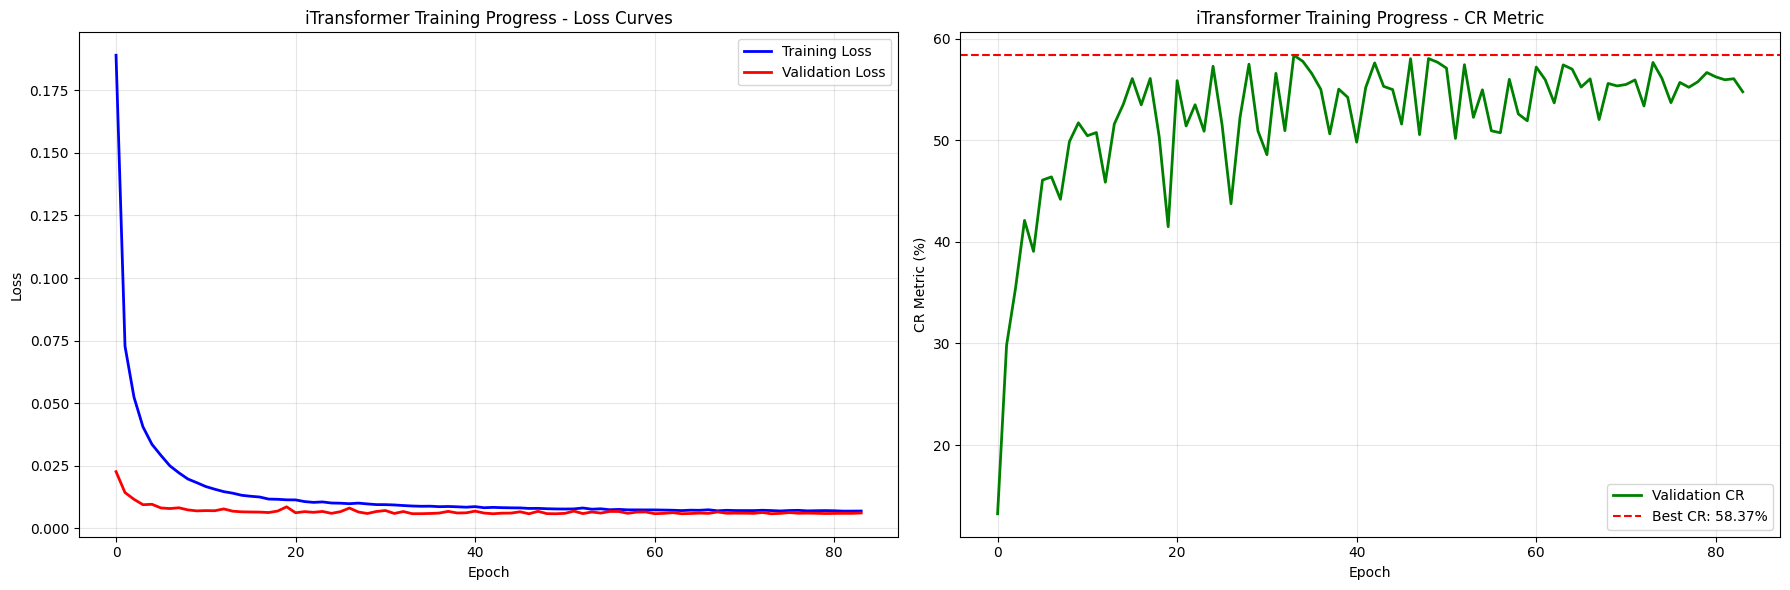


Model saved to: /data/jinming/ee_prediction/iTransformer/models/itransformer_16_point_best_model.pth
Best CR metric: 58.37%


In [10]:
# Plot training progress
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('iTransformer Training Progress - Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(val_cr_scores, label='Validation CR', color='green', linewidth=2)
plt.axhline(y=early_stopping.best_cr, color='red', linestyle='--', 
           label=f'Best CR: {early_stopping.best_cr:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('CR Metric (%)')
plt.title('iTransformer Training Progress - CR Metric')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save model
model_save_path = f'{config.model_save_dir}/itransformer_16_point_best_model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_cr_scores': val_cr_scores,
    'best_cr': early_stopping.best_cr,
    'best_epoch': best_epoch,
    'config': config.__dict__,
    'feature_names': train_dataset.feature_names,
    'model_info': {
        'model_type': 'iTransformer',
        'd_model': config.d_model,
        'nhead': config.nhead,
        'num_layers': config.num_encoder_layers,
        'total_params': total_params,
        'input_size': config.input_size
    }
}, model_save_path)

print(f"\nModel saved to: {model_save_path}")
print(f"Best CR metric: {early_stopping.best_cr:.2f}%")

In [11]:
# Test model performance
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    return predictions, targets

print("=== Testing iTransformer Model ===")
predictions, targets = test_model(model, test_loader, device)

print(f"Prediction shape: {predictions.shape}")
print(f"Target shape: {targets.shape}")

# Calculate step-wise metrics first
print(f"\n=== Step-wise Test Results ===")
step_mse = []
step_mae = []
step_cr = []

for step in range(16):
    step_targets = targets[:, step]
    step_predictions = predictions[:, step]
    
    mse = mean_squared_error(step_targets, step_predictions)
    mae = mean_absolute_error(step_targets, step_predictions)
    cr = calculate_CR(step_targets, step_predictions)
    
    step_mse.append(mse)
    step_mae.append(mae)
    step_cr.append(cr)
    
    print(f"Step {step+1:2d}: MSE={mse:.6f}, MAE={mae:.6f}, CR={cr:.2f}%")

# 16个时间尺度的平均指标
mse_average_across_steps = np.mean(step_mse)
mae_average_across_steps = np.mean(step_mae)
rmse_average_across_steps = np.sqrt(mse_average_across_steps)
cr_average_across_steps = np.mean(step_cr)

print(f"\nAverage metrics across 16 time steps:")
print(f"Average MSE: {mse_average_across_steps:.6f}")
print(f"Average RMSE: {rmse_average_across_steps:.6f}")  
print(f"Average MAE: {mae_average_across_steps:.6f}")
print(f"Average CR: {cr_average_across_steps:.2f}%")

# Overall metrics (flattened calculation)
mse_overall = mean_squared_error(targets.flatten(), predictions.flatten())
mae_overall = mean_absolute_error(targets.flatten(), predictions.flatten())
rmse_overall = np.sqrt(mse_overall)
cr_overall = calculate_CR(targets.flatten(), predictions.flatten())


print(f"\n=== Summary Statistics ===")
print(f"Average step-wise CR: {np.mean(step_cr):.2f}%")
print(f"Step-wise CR std: {np.std(step_cr):.2f}%")
print(f"Best step CR: {np.max(step_cr):.2f}% (Step {np.argmax(step_cr)+1})")
print(f"Worst step CR: {np.min(step_cr):.2f}% (Step {np.argmin(step_cr)+1})")

=== Testing iTransformer Model ===
Prediction shape: (2888, 16)
Target shape: (2888, 16)

=== Step-wise Test Results ===
Step  1: MSE=0.004241, MAE=0.046199, CR=76.86%
Step  2: MSE=0.007017, MAE=0.059274, CR=70.72%
Step  3: MSE=0.009056, MAE=0.068051, CR=66.71%
Step  4: MSE=0.011051, MAE=0.076041, CR=63.19%
Step  5: MSE=0.012688, MAE=0.081755, CR=60.35%
Step  6: MSE=0.014667, MAE=0.088254, CR=57.56%
Step  7: MSE=0.016230, MAE=0.092949, CR=55.95%
Step  8: MSE=0.017969, MAE=0.099365, CR=53.12%
Step  9: MSE=0.019556, MAE=0.103213, CR=51.41%
Step 10: MSE=0.020762, MAE=0.107109, CR=49.75%
Step 11: MSE=0.023224, MAE=0.113076, CR=46.72%
Step 12: MSE=0.024542, MAE=0.116387, CR=45.46%
Step 13: MSE=0.025615, MAE=0.118723, CR=44.04%
Step 14: MSE=0.027311, MAE=0.123117, CR=41.73%
Step 15: MSE=0.028942, MAE=0.127192, CR=39.96%
Step 16: MSE=0.030456, MAE=0.130993, CR=38.03%

Average metrics across 16 time steps:
Average MSE: 0.018333
Average RMSE: 0.135399
Average MAE: 0.096981
Average CR: 53.85%

=

In [12]:
# Save detailed results
os.makedirs(config.results_dir, exist_ok=True)

# Save prediction results
results_df = pd.DataFrame({
    'targets': targets.flatten(),
    'predictions': predictions.flatten(),
    'errors': targets.flatten() - predictions.flatten()
})
results_df.to_csv(f'{config.results_dir}/itransformer_16_point_predictions.csv', index=False)

# Save performance metrics
performance_summary = {
    'model_info': {
        'model_type': 'iTransformer',
        'd_model': config.d_model,
        'nhead': config.nhead,
        'num_layers': config.num_encoder_layers,
        'dim_feedforward': config.dim_feedforward,
        'total_params': int(total_params),
        'input_features': int(config.input_size)
    },
    'overall_metrics': {
        'MSE': float(mse_overall),
        'RMSE': float(rmse_overall),
        'MAE': float(mae_overall),
        'CR': float(cr_overall)
    },
    'step_wise_metrics': {
        'step': list(range(1, 17)),
        'MSE': [float(x) for x in step_mse],
        'MAE': [float(x) for x in step_mae],
        'CR': [float(x) for x in step_cr]
    },
    'training_info': {
        'best_validation_cr': float(early_stopping.best_cr),
        'best_epoch': int(best_epoch),
        'total_epochs': len(train_losses),
        'final_lr': float(optimizer.param_groups[0]['lr']),
        'early_stopping_criterion': 'CR_based'
    },
    'hyperparameters': {
        'seq_length': config.seq_length,
        'pred_length': config.pred_length,
        'd_model': config.d_model,
        'nhead': config.nhead,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'dropout': config.dropout
    }
}

import json
with open(f'{config.results_dir}/itransformer_16_point_performance.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

# Create detailed report
performance_report = f"""
# iTransformer Wind Power Prediction - Performance Report

## Model Architecture
- **Model Type**: iTransformer (Inverted Transformer)
- **Input Sequence**: {config.seq_length} points ({config.seq_length * config.time_interval_minutes / 60:.1f} hours)
- **Prediction Length**: {config.pred_length} points ({config.pred_length * config.time_interval_minutes / 60:.1f} hours)
- **Model Dimension**: {config.d_model}
- **Attention Heads**: {config.nhead}
- **Encoder Layers**: {config.num_encoder_layers}
- **Total Parameters**: {total_params:,}
- **Input Features**: {config.input_size}

## Training Results
- **Best Validation CR**: {early_stopping.best_cr:.2f}% (Epoch {best_epoch})
- **Total Training Epochs**: {len(train_losses)}
- **Final Learning Rate**: {optimizer.param_groups[0]['lr']:.2e}


## Step-wise Performance Analysis
- **Average CR**: {np.mean(step_cr):.2f}%
- **CR Standard Deviation**: {np.std(step_cr):.2f}%
- **Best Step**: Step {np.argmax(step_cr)+1} (CR: {np.max(step_cr):.2f}%)
- **Worst Step**: Step {np.argmin(step_cr)+1} (CR: {np.min(step_cr):.2f}%)

## Detailed Step-wise Metrics
"""

for i in range(16):
    performance_report += f"\n### Step {i+1} ({(i+1)*15} minutes ahead)"
    performance_report += f"\n- **CR**: {step_cr[i]:.2f}%"
    performance_report += f"\n- **RMSE**: {np.sqrt(step_mse[i]):.6f}"
    performance_report += f"\n- **MAE**: {step_mae[i]:.6f}\n"

with open(f'{config.results_dir}/itransformer_16_point_report.md', 'w', encoding='utf-8') as f:
    f.write(performance_report)

print("\n=== Results Saved ===")
print(f"- Predictions: {config.results_dir}/itransformer_16_point_predictions.csv")
print(f"- Performance: {config.results_dir}/itransformer_16_point_performance.json")
print(f"- Report: {config.results_dir}/itransformer_16_point_report.md")
print(f"- Model: {model_save_path}")




=== Results Saved ===
- Predictions: /data/jinming/ee_prediction/iTransformer/results/itransformer_16_point_predictions.csv
- Performance: /data/jinming/ee_prediction/iTransformer/results/itransformer_16_point_performance.json
- Report: /data/jinming/ee_prediction/iTransformer/results/itransformer_16_point_report.md
- Model: /data/jinming/ee_prediction/iTransformer/models/itransformer_16_point_best_model.pth
